# Ethiopia Mapping Section

This Python Jupyter file is to calculate and build out the requirements for the Ethiopian design. It could be possible to do this in Excel as well; but this way we have an ability to reference and redesign as per the changing requirements.

First Step is to collect the information; I have a Github account under my username (johnmeye) which i will reference from the file so that anyone who uses Conda/Jupyter will be able to get the files. For any challenges reach out to me on teams or by email (johnmeye@cisco.com)

In [1]:
from urllib.request import urlopen
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#For the Map Plotting
import plotly
import plotly.express as px

#Fo the Widgets
import ipywidgets as widgets #Importing Widgets to allow for the changing of variables on the fly as questions are asked.

In [2]:
RegionList = ['']

## Geographical Data

This file below is from the Ethiopian files available from the database on the following site:
https://data.humdata.org/dataset/ethiopia-population-data-_-admin-level-0-3

This site has both topography and the Level 0-3 admin data on the population levels per county/province. Vodacom only provided at Admin 1 (Provincial level) for this RFQ; but we are able to go more in depth to try and work out if there is any additional information we can use to strengthen our position.

The following section will pull that information from my Github; so that you don't have to fetch it yourself. Then load it as a JSON file into the DB, which you can see are Polygon type files with GPS coordinates which mark out the different layers/levels in the country. 

In [3]:
#Pull the Data I stored in my Github account for the analysis.

with urlopen('https://github.com/johnmeye/Ethiopia/raw/master/Ethiopia_JSON/eth_admbnda_adm1_csa_bofed_20190827.json') as response:
    counties1 = json.load(response)
    
with urlopen('https://github.com/johnmeye/Ethiopia/raw/master/Ethiopia_JSON/eth_admbnda_adm2_csa_bofed_20190827.json') as response:
    counties2 = json.load(response)
    
with urlopen('https://github.com/johnmeye/Ethiopia/raw/master/Ethiopia_JSON/eth_admbnda_adm3_csa_bofed_20190827.json') as response:
    counties3 = json.load(response)

#Feature Data is available in the JSON files but its easier to manage from a tableset so i have pulled this below as well.
    
Boundaries_Data1 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/eth_adminboundaries_tabulardata.xlsx",
                  sheet_name='Admin1')

Boundaries_Data3 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/eth_adminboundaries_tabulardata.xlsx",
                    sheet_name='Admin3')


In [4]:
counties3["features"][0]['properties'] #Just a sample on how to pull out specific information from the Counties json Files.

{'Shape_Leng': 1.95053223251,
 'Shape_Area': 0.171322798181,
 'ADM3_EN': 'Aba-Korow',
 'ADM3_PCODE': 'ET050699',
 'ADM3_REF': '',
 'ADM3ALT1EN': '',
 'ADM3ALT2EN': '',
 'ADM2_EN': 'Shabelle',
 'ADM2_PCODE': 'ET0506',
 'ADM1_EN': 'Somali',
 'ADM1_PCODE': 'ET05',
 'ADM0_EN': 'Ethiopia',
 'ADM0_PCODE': 'ET',
 'date': '2019-08-19T00:00:00.000Z',
 'validOn': '2019-08-27T00:00:00.000Z',
 'validTo': '1899-11-30T00:00:00.000Z'}

## Admin Level Data

As mentioned above; there is both Geo and Admin data; this information matches the information against some paramater; since the file is nicely structured according to standards we will stick to the humanitarian markings. 

Below i read the information from different levels into the variables for Admin1-3 so that we are able to use them to draw choropleth maps of the country. 

Once read into memory; it is possible to find matches against the specific parameters in both the GeoJSON and the Admin files. So i run a few sample commands to view what the data looks like. 



In [5]:
Admin1 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/ethiopia-population-data-_-admin-level-0-3.xlsx",
                   dtype={"admin1Pcode": str},
                   skiprows=[1],
                   sheet_name='Admin1')

Admin2 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/ethiopia-population-data-_-admin-level-0-3.xlsx",
                   dtype={"admin1Pcode": str},
                   skiprows=[1],
                   sheet_name='Admin2')

Admin3 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/ethiopia-population-data-_-admin-level-0-3.xlsx",
                   dtype={"admin1Pcode": str},
                   skiprows=[1],
                   sheet_name='Admin3')

In [6]:
Admin1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   admin1Name_en              11 non-null     object 
 1   admin1Pcode                11 non-null     object 
 2   admin0Name_en              11 non-null     object 
 3   admin0Pcode                11 non-null     object 
 4   Total Population           11 non-null     float64
 5    Male                      11 non-null     float64
 6    Female                    11 non-null     float64
 7   Children (under 18 years)  11 non-null     float64
 8   Adult (18 - 60 years)      11 non-null     float64
 9   Elderly (Above 60 years)   11 non-null     float64
dtypes: float64(6), object(4)
memory usage: 1008.0+ bytes


# Plotting the information on a Choropleth map

This information that we have gathered above needs to be represented in order to accurately help. 

Vodacom has provided Admin 1 information so we will plot against the Admin1 codes in the information. 

I have made it all at different levels so that some code can run quicker if need be.

In [7]:
#fig = px.choropleth_mapbox(Admin1, 
#                           geojson=counties1, 
#                           locations='admin1Pcode', featureidkey="properties.ADM1_PCODE",
#                           color='Total Population',
#                           color_continuous_scale="portland",
#                           range_color=(500000, 30000000),
#                           mapbox_style="carto-positron",
#                           zoom=3, center = {"lat": 9, "lon": 39},
#                           opacity=0.5,
#                           hover_name='admin1Name_en',
#                           labels={
#                            'Population_Density':'Population Density',
#                            'Total_Population':'Total Population',
#                            'admin1Name_en':'Province',
#                            'Area_Km':'Square Kilometer'
#                            },
#                          )
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#
#plotly.offline.plot(fig, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\EthiopiaAdmin1.html')

# Manipulating the data to find the sites requirements

Vodacom has provided the Ethiopia site numbers, and the expected by year and by type, although the Vodacom breaks it down by height and rooftop; this might not be necessary from our point of view and should not impact the way we calculate this. 

For this we will need to figure out how to define rural/urban and so forth.

In [8]:
Sites = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/TX%20BoQ%20v3-Python.xlsx",
                   sheet_name='Site_Numbers')

Sites.rename(columns = {'Location':'admin1Name_en'}, inplace = True)
Site_Year = Sites.groupby(['admin1Name_en']).sum()
TotalSites = pd.merge(Site_Year, Boundaries_Data1[['admin1Name_en', 'Shape_Area']],how='left', on=['admin1Name_en']) #Site combined with the geodata. Sizing found early.
TotalSites.rename(columns = {'Shape_Area':'Shape_Area_Admin1'}, inplace = True)


In [9]:
TotalSites.sum(axis = 0, skipna = True)

admin1Name_en        Addis AbabaAfarAmharaBenishangul GumzDire Dawa...
Year1                                                             1341
Year2                                                             1000
Year3                                                             1109
Year4                                                             1189
Year5                                                              881
Year6                                                             1253
Year7                                                             1203
Year8                                                             1222
Year9                                                             1386
Year10                                                            1456
Year11                                                            1684
Total                                                            13724
Shape_Area_Admin1                                              92.9219
dtype:

In [10]:
SiteTable = pd.merge(Admin3, TotalSites, how='outer', on=['admin1Name_en']) #Site by year

In [11]:
SiteTable.replace(to_replace=0, value=np.nan, inplace=True)

#Dropping a lot of information from Admin3 here to speed things up; we can return later if need be.
SiteTable.drop(SiteTable.iloc[:, 9:26], inplace = True, axis = 1) 
SiteTable.drop(SiteTable.iloc[:, 6:8], inplace = True, axis = 1) 
SiteTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   admin3Name_en      983 non-null    object 
 1   admin3Pcode        983 non-null    object 
 2   admin2Name_en      983 non-null    object 
 3   admin2Pcode        983 non-null    object 
 4   admin1Name_en      983 non-null    object 
 5   admin1Pcode        983 non-null    object 
 6   Total Population   982 non-null    float64
 7   Shape_Area_Admin1  983 non-null    float64
dtypes: float64(2), object(6)
memory usage: 69.1+ KB


In [12]:
Fulltable = pd.merge(SiteTable, Boundaries_Data3[['admin3Pcode', 'Shape_Area']],how='left', on=['admin3Pcode']) #Site combined with the geodata. Sizing found early.

Fulltable.sample()

,admin3Name_en,admin3Pcode,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,Total Population,Shape_Area_Admin1,Shape_Area
158,Gishe Rabel,ET030506,North Shewa,ET0305,Amhara,ET03,71429.555571,12.901454,0.054459


In [13]:
Fulltable['Shape_Area'] = Fulltable['Shape_Area'].fillna(0)

In [14]:
is_NaN = pd.isnull(Fulltable['Shape_Area'])

In [15]:
Fulltable[is_NaN]  

,admin3Name_en,admin3Pcode,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,Total Population,Shape_Area_Admin1,Shape_Area


### TODO: 
Plan is to create a dynamic image with the section below so that you can switch between the years and view what is happening.

In [16]:
#fig = px.choropleth_mapbox(Fulltable, 
#                           geojson=counties1, 
#                           locations='admin1Name_en', featureidkey="properties.ADM1_EN",
#                           color='Year1',
#                           color_continuous_scale="portland",
#                           range_color=(0, 350),
#                           mapbox_style="carto-positron",
#                           zoom=3, center = {"lat": 9, "lon": 39},
#                           opacity=0.5,
#                           
#                          )
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

# Calculating population density

The files provide a value for the size of the land and the overall land coverage. 1,104,300 square Km is the total size of the land in question. The following section shows the calculations used to determine the density for the various provinces. Which we are then able to use for the density and Rural/Urban calculations.

In [17]:
Ethiopia_Area = 1104300
Ethiopia_Shape_Area = Fulltable['Shape_Area'].sum()
print("Ethiopia Shape Area is:", Ethiopia_Shape_Area)
Unit_Area = Ethiopia_Area / Ethiopia_Shape_Area
Fulltable['Area_Km'] = Fulltable['Shape_Area'].apply(lambda x: x*Unit_Area)
Fulltable.rename(columns = {'Total Population':'Total_Population'}, inplace = True)
Fulltable.info()

Ethiopia Shape Area is: 93.378246
<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   admin3Name_en      984 non-null    object 
 1   admin3Pcode        984 non-null    object 
 2   admin2Name_en      984 non-null    object 
 3   admin2Pcode        984 non-null    object 
 4   admin1Name_en      984 non-null    object 
 5   admin1Pcode        984 non-null    object 
 6   Total_Population   983 non-null    float64
 7   Shape_Area_Admin1  984 non-null    float64
 8   Shape_Area         984 non-null    float64
 9   Area_Km            984 non-null    float64
dtypes: float64(4), object(6)
memory usage: 84.6+ KB


In [18]:
def POPDENSITY(Population,Area):
    try:
        Density=Population/Area
        return Density
    except ZeroDivisionError:
        return 0

Fulltable['Population_Density'] = Fulltable.apply(lambda x: POPDENSITY(x.Total_Population, x.Area_Km), axis=1)

In [19]:
Fulltable['Population_Density'].sample(10)

37       19.622726
388     185.005211
781     616.058880
712      37.583003
291     675.445503
938      81.728673
347     205.348245
873     359.783404
918      18.607937
289    1701.302992
Name: Population_Density, dtype: float64

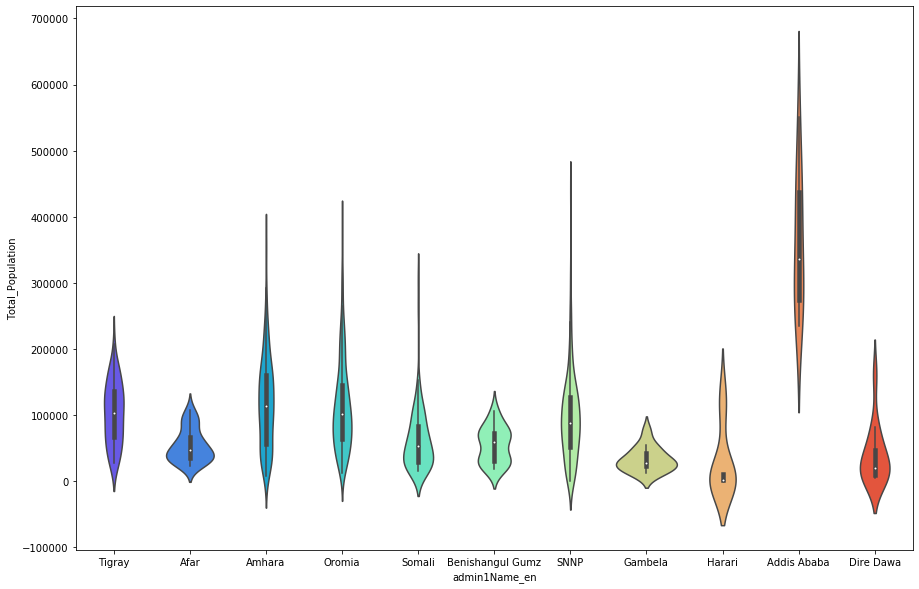

In [20]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.violinplot(x="admin1Name_en", y="Total_Population", data=Fulltable,palette='rainbow')
plt.show()

In [21]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=3, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en", "Total_Population", "Area_Km"],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                        },
                        title = TITLE
                        )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'

Color_ON    = 'Total_Population'

Pop_Map = CHOROMAP(Fulltable,JSON_ON, Location_ON, Feature_ON, Color_ON, 25000, 300000,'Population')

Color_ON    = 'Population_Density'

Dens_Map = CHOROMAP(Fulltable,JSON_ON, Location_ON, Feature_ON, Color_ON, 50, 500,'Population Density')


In [22]:
#plotly.offline.plot(Pop_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Population.html')
#plotly.offline.plot(Dens_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Population Density.html')
#

# Figuring out the site types

This is the step just prior to working out how many of each kind of router we will need. Now that we know about the different population densities; we can catagories them into the different catagories that they have provided for us. 

Catagories are: 
1. Dense-Urban
2. Urban
3. Sub-Urban
3. Rural
4. Deep-Rural

The result of this catagorising would be that the system would then know how the access type needs to be designed. The following image shows how they expect it to be.

![Microwave Connection](SiteConnection.png)

The breakdown would require then that there are specific rules in place for how many towers per catagory before we have a fibre connection. 

The Ethiopian Access Microwave network needs to ensure the highest level of stability. It is also important that network remains congestion free during failures. Therefore, the following guidelines should be adhered to:

1. Maximum of 4 Microwave Hops in a chain, 3 Hops in a chain according to capacities of the Vodafone calculator. The 4th hop (closest to the traditional BSC or aggregation backhaul point) needs to be protected. Plan for double the capacity required. These N+0 links must be used.
2. 5 Microwave sites in a star configuration (1st hop closest to the traditional BSC or aggregation point needs to be protected, planned for double capacity)
3. 4 Microwave Hops in chain protected by a full Microwave Ring 
4. 4 Microwave Hops in chain protected by a Mixed MW and Fibre Ring
5. Mesh topology with multiple aggregation points

The following image shows the planned layout of the network as per the Ethiotel backbone.

![Core Network](Core_Network.jpg)



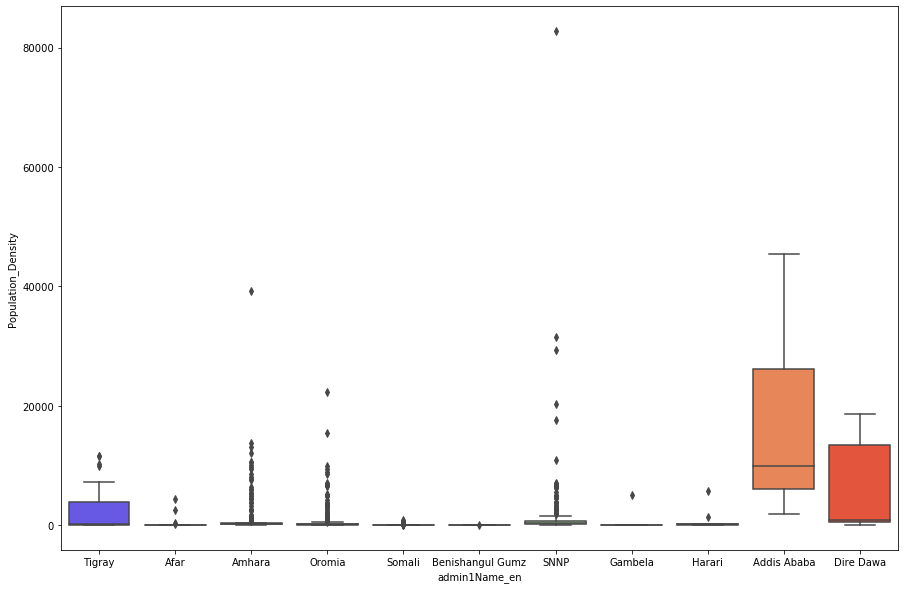

In [23]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.boxplot(x="admin1Name_en", y="Population_Density", data=Fulltable,palette='rainbow')


## Understanding the population density

The above figure shows that there is a some extremely dense portions of the country, Addis, Dire, Tigray, with some outlier towns in many of the other regions.

I suspect though that the towns might be showing as overly dense because rural people register at the towns and push up the numbers artificially. 

But we have two pieces of information which will help to decide what we do.

1. The population for a specific area
2. The calculated population density for an area which is calculated from the total country size and the region size.

Using these two together we should be able to place the regions into specific buckets. 

1. Dense Urban = Population Denser then 1000 people per km^2
2. Urban = Population Denser then 500 people but less then 1000 people per km^2
3. Sub-Urban = Population density between 200 and 500 people per km^2
4. Rural = Population density between 100 and 200 people per km^2
5. Deep-Rural = Population density less then 100 people per km^2

### Todo: Make this a dropdown so that we can select the range of each one to play around with it and figure out what is best.

In [24]:
DU_Thresh = 1000
U_Thresh = 500
SU_Thresh = 200
R_Thresh = 100
DR_Thresh = 0

def AREA_TYPE(Population_Density):
    if Population_Density >= DU_Thresh:
        return 'Dense Urban'
    elif U_Thresh <= Population_Density < DU_Thresh:
        return 'Urban'
    elif SU_Thresh <= Population_Density < U_Thresh:
        return 'Sub-Urban'
    elif R_Thresh <= Population_Density < SU_Thresh:
        return 'Rural'
    else:
        return 'Deep Rural'

Fulltable['Area_Type'] = Fulltable.apply(lambda x: AREA_TYPE(x.Population_Density), axis=1)

In [25]:
Fulltable['Area_Type'].value_counts()

Deep Rural     302
Rural          272
Sub-Urban      182
Dense Urban    158
Urban           70
Name: Area_Type, dtype: int64

In [26]:
Fulltable[Fulltable['admin1Name_en']=='Addis Ababa']['Area_Type'].value_counts()

Dense Urban    10
Name: Area_Type, dtype: int64

# Using Area_Type to define what Routers will be needed

## Information available

The Choropleth map can not be subdivided into regions and sites. We have the information on the following to help make this decision

1. Population in an area
2. Size of an area
3. Type of area
4. Number of sites planned by vodacom for the area

## Site counts

Vodacom has given the number of sites it plans on a provincial level. But as can already be seen by the images above, the sites are extremely large and should be broken down further. Their methods they used was to break up the area types per year, Rural/Suburban etc... The question now comes in on how to approach this division. 

## Site connectivity
With this information we should be able to make the decision of how to split up the sites and how to connect them.

The breakdown is as follows:

1. For Rural and Deep Rural; the sites will all be MW linking back to the backhaul via MW sites. 
2. For Sub-Urban we will be able to have a mix of MW and Fibre, back to the nearest Urban location. Typically less then 80km away. 
3. For the Urbun and Dense-Urbun, we will be able to have fibre exclusively according to Vodacom planning.


In [27]:
for i in Fulltable.admin1Name_en.unique():
    
    Area_Breakdown = Fulltable[Fulltable['admin1Name_en']== i]['Area_Type'].value_counts()
    print(i)
    print(Area_Breakdown)


Tigray
Rural          21
Dense Urban    18
Deep Rural     13
Name: Area_Type, dtype: int64
Afar
Deep Rural     31
Dense Urban     2
Rural           1
Sub-Urban       1
Name: Area_Type, dtype: int64
Amhara
Rural          83
Dense Urban    38
Sub-Urban      30
Deep Rural     28
Urban           4
Name: Area_Type, dtype: int64
Oromia
Rural          117
Sub-Urban       88
Deep Rural      82
Dense Urban     39
Urban           10
Name: Area_Type, dtype: int64
Somali
Deep Rural    85
Rural          7
Sub-Urban      4
Urban          3
Name: Area_Type, dtype: int64
Benishangul Gumz
Deep Rural    19
Rural          1
Name: Area_Type, dtype: int64
SNNP
Sub-Urban      59
Urban          49
Dense Urban    42
Rural          36
Deep Rural     26
Name: Area_Type, dtype: int64
Gambela
Deep Rural     14
Dense Urban     1
Name: Area_Type, dtype: int64
Harari
Deep Rural     4
Rural          3
Dense Urban    2
Name: Area_Type, dtype: int64
Addis Ababa
Dense Urban    10
Name: Area_Type, dtype: int64
Dire Dawa


In [28]:
dfDU = Fulltable[Fulltable['Area_Type']=='Dense Urban']
dfU = Fulltable[Fulltable['Area_Type']=='Urban']
dfSU = Fulltable[Fulltable['Area_Type']=='Sub-Urban']
dfR = Fulltable[Fulltable['Area_Type']=='Rural']
dfDR = Fulltable[Fulltable['Area_Type']=='Deep Rural']

In [29]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=3, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en", "Total_Population", "Area_Km"],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                                },
                        title = TITLE
                          )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'
Color_ON    = 'Population_Density'

DU_Map = CHOROMAP(dfDU,JSON_ON, Location_ON, Feature_ON, Color_ON, DU_Thresh, 5000,'Dense Urban')
U_Map  = CHOROMAP(dfU,JSON_ON, Location_ON, Feature_ON, Color_ON, U_Thresh, DU_Thresh, 'Urban')
SU_Map = CHOROMAP(dfSU,JSON_ON, Location_ON, Feature_ON, Color_ON, SU_Thresh, U_Thresh, 'Sub Urban')
R_Map  = CHOROMAP(dfR,JSON_ON, Location_ON, Feature_ON, Color_ON, R_Thresh, SU_Thresh, 'Rural')
DR_Map = CHOROMAP(dfDR,JSON_ON, Location_ON, Feature_ON, Color_ON, DR_Thresh, R_Thresh, 'Deep Rural')



In [30]:
plotly.offline.plot(DU_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\DU_Map.html')
#plotly.offline.plot(U_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\U_Map.html')
#plotly.offline.plot(SU_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\SU_Map.html')
#plotly.offline.plot(R_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\R_Map.html')
#plotly.offline.plot(DR_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\DR_Map.html')

## Dividing the Cell Towers into regions

The challenge comes from the division of the towers up into the various areas. We know what areas are considered Urban/Sub-Urban and so forth. A choice must be made how to split each year's towers up.

The other choice would be if each area in the province should get a tower. In the deep rural sites this might not be entirely possible. 

For now the choice i will make is to divide the towers up proportionally to the amount of people who live in the specific province. Should this be an issue we can rework on this calculation again after meeting with Vodacom.

The total Sites keeps the information for the sites by year.



In [131]:
###
#So i found this section of code on StackExchange trying to figure out how to do this kind of calculation. 
#ultimately its quite complex to handle the multiple index's and locations to build out the sites. 
#This code works out the percentage of population in each province that lives in the specific Admin3 area.
#The sum of the percentages in each Admin3 will add to 100% in their respective Admin1 level.
###

Population_Grouping = Fulltable.groupby(['admin1Name_en','admin3Name_en']).agg({'Total_Population': 'sum'})
Population_PCT = Population_Grouping.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))


Proportional = Population_PCT.reset_index() #If you want to convert back to a normal dataframe and not a Multi-Index frame.

#Making a Sites Rollout sheet to work out how to build out the sites.
Sites_Rollout = Fulltable[['admin1Name_en','admin3Pcode','admin3Name_en','Area_Type']]
Sites_Rollout = pd.merge(Sites_Rollout, TotalSites, how="left", on=["admin1Name_en"])
Sites_Rollout = pd.merge(Sites_Rollout, Proportional[['Total_Population','admin3Name_en']], how="left", on=["admin3Name_en"])

## Working out the Sites Rollout for a specific area

The challenge has always been to breakdown how the sites will be broken down. 

Below you will see there are two tables; the Sites_Rollout (Which was calculated by us with the help of understanding what the population grouping is), so this breaks the rollout into the specific Admin3 areas. I show both the admin1/admin3 grouping and the admin1 summation. 

The second one is the Table provided by Vodacom for this rollout. 

### Discrepencies

1. This occurs because i'm having to use some imprecise rounding on the populations. Because we are linking to the percentage of the population subgroup there will always be decimals. 

     a. The option exists to round-up as well; so sites which have below 0.5 sites scheduled for whatever reason would be able to get a site. But this might mean that we build into extremely remote regions. 
     

2. I adjusted the area of one or two of the areas in the admin3 area. This was because they had a NaN input but did have an area, so i calculated it; but it now makes some areas add up to more then 100%. Which is not a big problem for now. 


In [132]:
Sites_Rollout

,admin1Name_en,admin3Pcode,admin3Name_en,Area_Type,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Total,Shape_Area_Admin1,Total_Population
0,Tigray,ET010101,Tahtay Adiyabo,Deep Rural,53,10,126,152,15,130,107,114,110,67,75,959,4.399121,1.953604
1,Tigray,ET010102,Laelay Adiabo,Deep Rural,53,10,126,152,15,130,107,114,110,67,75,959,4.399121,2.380621
2,Tigray,ET010103,Medebay Zana,Rural,53,10,126,152,15,130,107,114,110,67,75,959,4.399121,2.727719
3,Tigray,ET010104,Tahtay Koraro,Rural,53,10,126,152,15,130,107,114,110,67,75,959,4.399121,1.445040
4,Tigray,ET010105,Asgede Tsimbila,Deep Rural,53,10,126,152,15,130,107,114,110,67,75,959,4.399121,3.031744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Dire Dawa,ET150114,Police Maret,Urban,44,0,0,0,0,17,20,30,17,4,6,138,0.086757,0.952289
982,Dire Dawa,ET150201,Aseliso,Urban,44,0,0,0,0,17,20,30,17,4,6,138,0.086757,13.297425
983,Dire Dawa,ET150206,Jeldessa,Rural,44,0,0,0,0,17,20,30,17,4,6,138,0.086757,9.308961
984,Dire Dawa,ET150207,Wahil,Rural,44,0,0,0,0,17,20,30,17,4,6,138,0.086757,6.957731


In [133]:
for column in Sites_Rollout.iloc[:, 4:15]:
    Sites_Rollout[column] =np.round(Sites_Rollout[column]*Sites_Rollout['Total_Population']/100)

Sites_Rollout['Total'] =Sites_Rollout.iloc[:, 4:15].sum(axis=1)


In [134]:
Sites_Rollout.replace(0, np.nan, inplace=True)

In [135]:
Sites_Rollout

,admin1Name_en,admin3Pcode,admin3Name_en,Area_Type,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Total,Shape_Area_Admin1,Total_Population
0,Tigray,ET010101,Tahtay Adiyabo,Deep Rural,1.0,NaN,2.0,3.0,NaN,3.0,2.0,2.0,2.0,1.0,1.0,17.0,4.399121,1.953604
1,Tigray,ET010102,Laelay Adiabo,Deep Rural,1.0,NaN,3.0,4.0,NaN,3.0,3.0,3.0,3.0,2.0,2.0,24.0,4.399121,2.380621
2,Tigray,ET010103,Medebay Zana,Rural,1.0,NaN,3.0,4.0,NaN,4.0,3.0,3.0,3.0,2.0,2.0,25.0,4.399121,2.727719
3,Tigray,ET010104,Tahtay Koraro,Rural,1.0,NaN,2.0,2.0,NaN,2.0,2.0,2.0,2.0,1.0,1.0,15.0,4.399121,1.445040
4,Tigray,ET010105,Asgede Tsimbila,Deep Rural,2.0,NaN,4.0,5.0,NaN,4.0,3.0,3.0,3.0,2.0,2.0,28.0,4.399121,3.031744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Dire Dawa,ET150114,Police Maret,Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086757,0.952289
982,Dire Dawa,ET150201,Aseliso,Urban,6.0,NaN,NaN,NaN,NaN,2.0,3.0,4.0,2.0,1.0,1.0,19.0,0.086757,13.297425
983,Dire Dawa,ET150206,Jeldessa,Rural,4.0,NaN,NaN,NaN,NaN,2.0,2.0,3.0,2.0,NaN,1.0,14.0,0.086757,9.308961
984,Dire Dawa,ET150207,Wahil,Rural,3.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,NaN,8.0,0.086757,6.957731


In [137]:
Sites_Rollout.groupby(['admin1Name_en','Area_Type','admin3Name_en']).sum()

Year1  Year2  Year3  Year4  Year5  \
admin1Name_en Area_Type   admin3Name_en                                         
Addis Ababa   Dense Urban Addis Ketema       26.0    0.0    0.0    0.0    0.0   
                          Akaki - Kalit      18.0    0.0    0.0    0.0    0.0   
                          Arada              21.0    0.0    0.0    0.0    0.0   
                          Bole               33.0    0.0    0.0    0.0    0.0   
                          Gulele             27.0    0.0    0.0    0.0    0.0   
...                                           ...    ...    ...    ...    ...   
Tigray        Rural       Ofla                1.0    0.0    3.0    4.0    0.0   
                          Saesie Tsaedamba    2.0    0.0    4.0    5.0    0.0   
                          Tahtay Koraro       1.0    0.0    2.0    2.0    0.0   
                          Tahtay Mayechew     1.0    0.0    2.0    3.0    0.0   
                          Werei Leke          2.0    0.0    4.0    5.0    0.0   

                                            Year6  Year7  Year8  Year9  \
admin1Name_en Area_Type   admin3Name_en                                  
Addis Ababa   Dense Urban Addis Ketema        9.0    6.0   14.0   23.0   
                          Akaki - Kalit       6.0    4.0   10.0   17.0   
                          Arada               7.0    5.0   12.0   19.0   
                          Bole               11.0    8.0   18.0   29.0   
                          Gulele              9.0    7.0   15.0   24.0   
...                                           ...    ...    ...    ...   
Tigray        Rural       Ofla                3.0    3.0    3.0    3.0   
                          Saesie Tsaedamba    4.0    3.0    4.0    3.0   
                          Tahtay Koraro       2.0    2.0    2.0    2.0   
                          Tahtay Mayechew     3.0    2.0    2.0    2.0   
                          Werei Leke          4.0    3.0    4.0    4.0   

                                            Year10  Year11  Total  \
admin1Name_en Area_Type   admin3Name_en                             
Addis Ababa   Dense Urban Addis Ketema         2.0     1.0   81.0   
                          Akaki - Kalit        2.0     0.0   57.0   
                          Arada                2.0     0.0   66.0   
                          Bole                 3.0     1.0  103.0   
                          Gulele               2.0     1.0   85.0   
...                                            ...     ...    ...   
Tigray        Rural       Ofla                 2.0     2.0   24.0   
                          Saesie Tsaedamba     2.0     2.0   29.0   
                          Tahtay Koraro        1.0     1.0   15.0   
                          Tahtay Mayechew      1.0     1.0   17.0   
                          Werei Leke           2.0     2.0   30.0   

                                            Shape_Area_Admin1  \
admin1Name_en Area_Type   admin3Name_en                         
Addis Ababa   Dense Urban Addis Ketema               0.044369   
                          Akaki - Kalit              0.044369   
                          Arada                      0.044369   
                          Bole                       0.044369   
                          Gulele                     0.044369   
...                                                       ...   
Tigray        Rural       Ofla                       4.399121   
                          Saesie Tsaedamba           4.399121   
                          Tahtay Koraro              4.399121   
                          Tahtay Mayechew            4.399121   
                          Werei Leke                 4.399121   

                                            Total_Population  
admin1Name_en Area_Type   admin3Name_en                       
Addis Ababa   Dense Urban Addis Ketema              9.143184  
                          Akaki - Kalit             6.548580  
                          Arada

In [149]:
Sites_Rollout.groupby('Area_Type').sum()

,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Total,Shape_Area_Admin1,Total_Population
Area_Type,,,,,,,,,,,,,,
Deep Rural,336.0,141.0,191.0,279.0,233.0,288.0,348.0,299.0,370.0,244.0,467.0,3196.0,5380.645010,424.103782
Dense Urban,409.0,92.0,111.0,119.0,63.0,206.0,165.0,272.0,354.0,172.0,155.0,2118.0,1996.294674,319.729165
Rural,342.0,412.0,424.0,393.0,243.0,419.0,377.0,357.0,364.0,499.0,583.0,4413.0,4772.812093,206.446881
Sub-Urban,183.0,276.0,288.0,300.0,231.0,271.0,233.0,220.0,214.0,392.0,418.0,3026.0,3353.343261,93.578815
Urban,36.0,61.0,72.0,96.0,71.0,64.0,59.0,52.0,34.0,135.0,78.0,758.0,830.597437,56.818765


In [147]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=5, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en", "Year1", "Year2", "Year3","Year4", "Year5", "Year6" ],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                                },
                        title = TITLE
                          )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'
Color_ON    = 'Year1'

for i in range(1,12):
    Color_ON    = 'Year'+str(i)
    Title       = "Rollout Year " + str(i)
    Saved       = r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Sites_Rollout_Map'+str(i)+'.html'
    Sites_Rollout_Map = CHOROMAP(Sites_Rollout, JSON_ON, Location_ON, Feature_ON, Color_ON, 0, 5, Title)
    plotly.offline.plot(Sites_Rollout_Map, filename=Saved)



'C:\\Users\\johnmeye\\Documents\\GitHub\\Ethiopia\\Plotly\\Sites_Rollout_Map.html'

In [36]:
admin1Name_en_Sites_Rollout = Sites_Rollout.groupby('admin1Name_en').sum()
admin1Name_en_Sites_Rollout

,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Total,Shape_Area_Admin1,Total_Population
admin1Name_en,,,,,,,,,,,,,,
Addis Ababa,281.0,0.0,0.0,0.0,0.0,94.0,67.0,155.0,252.0,25.0,6.0,880.0,0.443690,100.000000
Afar,60.0,0.0,0.0,40.0,44.0,25.0,66.0,30.0,66.0,18.0,70.0,419.0,275.785335,100.000000
Amhara,366.0,424.0,262.0,131.0,32.0,251.0,220.0,194.0,198.0,359.0,414.0,2851.0,2360.966082,100.000000
Benishangul Gumz,30.0,0.0,0.0,20.0,31.0,34.0,38.0,34.0,47.0,0.0,33.0,267.0,82.986100,100.000000
Dire Dawa,43.0,0.0,0.0,0.0,0.0,15.0,20.0,31.0,15.0,3.0,5.0,132.0,1.127841,100.000000
Gambela,14.0,0.0,0.0,7.0,12.0,12.0,13.0,29.0,37.0,0.0,14.0,138.0,38.413650,100.000000
Harari,30.0,0.0,0.0,2.0,0.0,3.0,7.0,22.0,16.0,0.0,13.0,93.0,0.274608,100.000000
Oromia,226.0,419.0,501.0,519.0,466.0,488.0,400.0,423.0,446.0,537.0,769.0,5194.0,8921.960420,100.531232
SNNP,29.0,134.0,178.0,257.0,178.0,127.0,111.0,67.0,24.0,386.0,131.0,1622.0,1901.776464,100.146176


## Dividing the sites up to calculate Fibre and MW site counts

We have already identified the sites numbers per region, divided up the deployment sites into the area.

The next step is to now divids the Area-types up. Technically the area_type is already available, but we would need to make some decisions around this. 

I have chosen to do the following:

1. Dense Urban and Urban are all Fibre Sites, so each site is 1:1 and Access Type switch with an NCS540.
2. The Sub-Urban sites will be some Fibre and Some MW, I will make an Assumption of 50:50 for this to start.
3. The Rural and Deep Rural sites are all MW. 

So we will have three dataframes to do these calculations.

In [81]:
Full_Fibre = Sites_Rollout[(Sites_Rollout['Area_Type']=='Urban') | (Sites_Rollout['Area_Type']=='Dense Urban') ]
Mixed = Sites_Rollout[(Sites_Rollout['Area_Type']=='Sub-Urban')]
Full_MW = Sites_Rollout[(Sites_Rollout['Area_Type']=='Rural') | (Sites_Rollout['Area_Type']=='Deep Rural') ]

In [98]:
for column in Full_Fibre.iloc[:, 3:14]:
    Fibre_Column = 'Fibre'+str(column)
    MW_Column = 'MW'+ str(column)
    Full_Fibre.loc[:,(Fibre_Column)] = Full_Fibre.loc[:,(column)]*1
    Full_Fibre.loc[:,(MW_Column)] = 0


In [88]:
for column in Mixed.iloc[:, 3:14]:
    Fibre_Column = 'Fibre'+str(column)
    MW_Column = 'MW'+ str(column)
    Mixed.loc[:,(Fibre_Column)] = Mixed.loc[:,(column)]*0.5
    Mixed.loc[:,(MW_Column)] = Mixed.loc[:,(column)]*0.5

In [101]:
for column in Full_MW.iloc[:, 3:14]:
    Fibre_Column = 'Fibre'+str(column)
    MW_Column = 'MW'+ str(column)
    Full_MW.loc[:,(Fibre_Column)] = 0
    Full_MW.loc[:,(MW_Column)] = Full_MW.loc[:,(column)]*1
    

## Microwave as an option

If there is active sharing on a site; without applying, shaping and managing bandwidth; Microwave is extremely limited in its ability to share the network. 

Ethiotel is requesting that this is enforced. 

The request is that this is an end to end IP. So we must assume that the MW can Guaranty QoS fidelity for Vodafone and the sharing partner. 

The main issue will come with the requirement for the sharing. If there is an enterprise customer for example; how will they connect this enterprise to a vpn and the microwave. 


In [102]:
Full_MW


,admin1Name_en,admin3Name_en,Area_Type,Year1,Year2,Year3,Year4,Year5,Year6,Year7,...,FibreYear7,MWYear7,FibreYear8,MWYear8,FibreYear9,MWYear9,FibreYear10,MWYear10,FibreYear11,MWYear11
0,Tigray,Tahtay Adiyabo,Deep Rural,53,10,126,152,15,130,107,...,0,107,0,114,0,110,0,67,0,75
1,Tigray,Laelay Adiabo,Deep Rural,53,10,126,152,15,130,107,...,0,107,0,114,0,110,0,67,0,75
2,Tigray,Medebay Zana,Rural,53,10,126,152,15,130,107,...,0,107,0,114,0,110,0,67,0,75
3,Tigray,Tahtay Koraro,Rural,53,10,126,152,15,130,107,...,0,107,0,114,0,110,0,67,0,75
4,Tigray,Asgede Tsimbila,Deep Rural,53,10,126,152,15,130,107,...,0,107,0,114,0,110,0,67,0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,Harari,Amir Nur,Deep Rural,32,0,0,2,0,3,8,...,0,8,0,23,0,16,0,0,0,13
961,Harari,Aboker,Rural,32,0,0,2,0,3,8,...,0,8,0,23,0,16,0,0,0,13
983,Dire Dawa,Jeldessa,Rural,44,0,0,0,0,17,20,...,0,20,0,30,0,17,0,4,0,6
984,Dire Dawa,Wahil,Rural,44,0,0,0,0,17,20,...,0,20,0,30,0,17,0,4,0,6
